In [1]:
def max_carbon(stringlike, carbon):
    """ 
    params:
    =======
    stringlike: <str> like residue, like "20:3"
    carbon    : <int> The maximum number of carbon atoms allowed.
    
    returns:
    ========
    True if <stringlike> within <carbon> allowed number of residues, False otherwise
    """
    if not isinstance(carbon, (int, float)):
        raise TypeError(f"Max carbon atoms must be a number")
    
    try:
        backbone = int(stringlike[:stringlike.find(":")])
        
        if backbone <= carbon:
            return True
        else:
            return False
    except (TypeError, ValueError):
        raise TypeError(f"'{stringlike}' must be in the form (example): '20:3'")

In [2]:
def saturated(stringlike):
    """ Accepts strings in the form: 20:3
    Returns True if fatty residue is saturated, False otherwise.
    
    params:
    =======
    stringlike: <str> like residue, like "20:3"
    
    returns:
    ========
    True if the residue is saturated, False otherwise
    """
    try:
        sat = int(stringlike[stringlike.find(":")+1:])
        if sat > 0:
            return False
        else:
            return True
    except (TypeError, ValueError):
        raise TypeError(f"'{stringlike}' must be in the form (example): '20:3'")


# Example analysis of a publicly available dataset

This is an exploratory analysis of publicly available data from:
https://www.metabolomicsworkbench.org/data/DRCCMetadata.php?Mode=Study&StudyID=ST000668&StudyType=MS&ResultType=1

As requested, we do include this statement that comes with data:

> This data is available at the NIH Common Fund's National Metabolomics Data Repository (NMDR) website, the Metabolomics Workbench, https://www.metabolomicsworkbench.org, where it has been assigned Project ID PR000471. The data can be accessed directly via it's Project DOI: 10.21228/M85P6M This work is supported by NIH grant, U2C- DK119886.

# Data preprocessing

In [3]:
# Author: stefano.manzini@gmail.com
# http://www.stemanz.altervista.org/
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from liputils import Lipid, make_residues_table
import pandas as pd
import numpy as np
from collections import Counter
import requests

Downloading the files from the repository in the local folder.

In [4]:
# data comes in two tables, from positive and negative ion modes

url1 = "https://www.metabolomicsworkbench.org/data/study_textformat_view.php?STUDY_ID=ST000668&ANALYSIS_ID=AN001022&MODE=d"
url2 = "https://www.metabolomicsworkbench.org/data/study_textformat_view.php?STUDY_ID=ST000668&ANALYSIS_ID=AN001023&MODE=d"
    
req1 = requests.get(url1, allow_redirects=False)
with open("ST000668_AN001022.csv", "wb") as o:
    o.write(req1.content)

req2 = requests.get(url2, allow_redirects=False)
with open("ST000668_AN001023.csv", "wb") as o:
    o.write(req2.content)

In [5]:
# manual inspection of the downloaded files is required to know how many rows
# need to be skipped to yield a non-malformed table
df1 = pd.read_csv("ST000668_AN001022.csv", sep="\t", skiprows=109)
df2 = pd.read_csv("ST000668_AN001023.csv", sep="\t", skiprows=109)

Even if it is hosted on Metabolomics Workbench, the is not 100% fully RefMet compliant. Before we use ```liputils```, we want to use the online translator to convert all names into RefMet compliant ones. Before we do that, we must help the online translator by removing all unnecessary clutter from the analyte names.

In [6]:
# analytes contain information that prevent Metabolomics Workbench
# name translator from understanding who they are
# https://www.metabolomicsworkbench.org/databases/refmet/name_to_refmet.php
# example: CL 70:1; [M-2H](2-)@6.86
# it needs to be: CL 70:1

df1["Samples"] = df1["Samples"].apply(lambda x: x[:x.find(";")] if ";" in x else x)
df1["Samples"] = df1["Samples"].apply(lambda x: x[:x.find("[")] if "]" in x else x)
df2["Samples"] = df2["Samples"].apply(lambda x: x[:x.find(";")] if ";" in x else x)
df2["Samples"] = df2["Samples"].apply(lambda x: x[:x.find("[")] if "[" in x else x)

In [7]:
# the last two rows do not contain lipidomics data:
df1["Samples"][-3:]

248    plasmenyl-PE 42:5
249      METABOLITES_END
250                 #END
Name: Samples, dtype: object

In [8]:
df1 = df1.iloc[:-2,:]
df2 = df2.iloc[:-2,:]

In [9]:
#checking if columns are equal. If they are, we merge the two dataframes
for x,y in zip(df1.columns, df2.columns):
    assert x == y

In [10]:
df = pd.concat([df1, df2], axis=0)

In [11]:
# this study uses a notation that is not RefMet compliant. We need to get
# online and retrieve translated terms from
# https://www.metabolomicsworkbench.org/databases/refmet/name_to_refmet.php

In [12]:
df = df.set_index("Samples")

In [13]:
# making a textfile with all analytes
with open("analytes.txt", "w") as o:
    for analyte in df.index:
        o.write(analyte+"\n")

In [14]:
# after manually inputting the analyte list in Metabolomics Workbench, a
# txt table of translated inputs is dowloaded. We load this table:
translated = pd.read_csv("refmet_results.txt", sep="\t")
translated.head(10)

,Input name,RefMet name,Formula,Mass,REGNO
0,Factors,NaN,NaN,NaN,NaN
1,CL 70:1,CL(70:1),C79H152O17P2,1435.0505,NaN
2,CL 70:5,CL(70:5),C79H144O17P2,1426.9879,NaN
3,CL 74:1,CL(74:1),C83H160O17P2,1491.1131,NaN
4,CL 74:7,CL(74:7),C83H148O17P2,1479.0192,NaN
5,CL 82:13,NaN,NaN,NaN,NaN
6,FFA(20:0),Arachidic acid,C20H40O2,312.3028,41.0
7,FFA(20:1),Heneicosenoic acid,C21H40O2,324.3028,NaN
8,FFA(20:2),Eicosadienoic acid,C20H36O2,308.2715,NaN
9,FFA(22:0),Behenic acid,C22H44O2,340.3341,43.0


In [15]:
# not all inputs were translated (Factors, on row 0, is an artifact from the old index)
translated.iloc[0,1] = "Factors" # replacing NaN with "Factors"

In [16]:
assert df.shape[0] == translated.shape[0]

In [17]:
# The tables have the same number of rows, so we can put the translated
# indices back into the former table, then drop all non translated
# compound (this is why we put back "Factors", as we still need to give labels
# to samples)

In [18]:
df["RefMet name"] = list(translated["RefMet name"])
df = df.dropna()
print(f"Total number of lipids: {df.shape[0]}")

Total number of lipids: 482


In [19]:
# it would be a good thing to rapidly identify each sample in terms of treatment,
# as well as stratify data. Let's get to know the different experimental conditions:
print(f"These are the possible experimental conditions:\n{'='*80}")
for c in set(df.loc["Factors",df.columns[:-1]]):
    print(c)

These are the possible experimental conditions:
Diet intervention:Saturated Fatty Acid | Gender:female
Diet intervention:Baseline | Gender:female
Diet intervention:Overfeeding-2 weeks | Gender:female
Diet intervention:Baseline | Gender:male
Diet intervention:Unsaturated Fatty Acid | Gender:female
Diet intervention:Overfeeding-2 weeks | Gender:male


In [20]:
# we are going to modify the table a bit, so we save some info about
# the samples for future reference
sample_book = {k:v for k,v in zip(df.columns[:-1], df.loc["Factors", df.columns[:-1]])}

In [21]:
# final preparation of the table for residue extraction. Setting the index with
# RefMet compliant lipid names
df = df.set_index("RefMet name")

In [22]:
df = df.drop(["Factors"])

## Please note! ##
We need to **make sure that numeric data gets interpreted as numeric**, otherwise it will be discarded later on.

In [23]:
# liputils drops any non-numerical column by default.
# pandas has not interpreted the numbers in the table as numbers,
# so before proceeding we tell it that the table actually contains numbers.
df = df.astype("float64")

In [24]:
# This is what the final, polished table looks like
df.head()

,S00019182,S00019183,S00019184,S00019185,S00019186,S00019187,S00019188,S00019189,S00019190,S00019191,...,S00019216,S00019217,S00019218,S00019219,S00019220,S00019221,S00019222,S00019223,S00019224,S00019225
RefMet name,,,,,,,,,,,,,,,,,,,,,
CL(70:1),1.415543e+05,1.356717e+05,4.174906e+04,4.683934e+04,6.963792e+04,5.236800e+04,4.547943e+04,6.025839e+04,4.973006e+04,6.963792e+04,...,6.025839e+04,3.062563e+04,5.400946e+04,6.963792e+04,3.062563e+04,7.563810e+04,3.487281e+04,6.486346e+04,7.969227e+04,1.415543e+05
CL(70:5),5.700773e+04,2.957225e+04,1.253442e+04,9.635603e+03,2.957225e+04,1.524695e+04,2.039487e+04,2.451510e+04,1.824171e+04,1.887783e+04,...,1.824171e+04,1.461368e+04,1.331253e+04,2.291821e+04,8.841766e+03,3.375496e+04,1.681784e+04,2.123454e+04,1.824171e+04,5.095133e+04
CL(74:1),4.295867e+04,5.400946e+04,2.451510e+04,3.276228e+04,4.427461e+04,2.548709e+04,4.065943e+04,4.683934e+04,2.380501e+04,2.700821e+04,...,3.160627e+04,2.039487e+04,2.548709e+04,5.236800e+04,4.683934e+04,6.246351e+04,3.594479e+04,3.375496e+04,6.025839e+04,5.236800e+04
CL(74:7),6.722344e+04,1.681784e+04,5.551705e+04,2.618583e+04,4.973006e+04,2.618583e+04,8.275527e+04,3.062563e+04,4.174906e+04,2.291821e+04,...,2.123454e+04,4.683934e+04,3.931035e+04,2.957225e+04,2.291821e+04,3.847923e+04,5.838209e+04,1.681784e+04,3.276228e+04,3.276228e+04
Arachidic acid,1.701166e+06,1.161941e+06,1.399456e+06,1.399456e+06,1.399456e+06,1.399456e+06,1.399456e+06,1.399456e+06,1.285736e+06,1.285736e+06,...,1.285736e+06,1.701166e+06,1.399456e+06,1.399456e+06,1.285736e+06,1.285736e+06,1.701166e+06,1.399456e+06,1.399456e+06,1.285736e+06


# Extraction of lipid residues with liputils

We directly feed our data table to ```make_residues_table()```. This function returns a ```pandas.DataFrame``` and expects analytes as row index and samples as column index.

In [25]:
res = make_residues_table(df)

# residues are pulled in appearance order, so they need to be ordered
res = res.sort_index()
res.head()

,S00019182,S00019183,S00019184,S00019185,S00019186,S00019187,S00019188,S00019189,S00019190,S00019191,...,S00019216,S00019217,S00019218,S00019219,S00019220,S00019221,S00019222,S00019223,S00019224,S00019225
14:0,3.474830e+04,4.356682e+04,2.608958e+04,3.404043e+04,2.561295e+04,2.388370e+04,2.784819e+04,5.753333e+04,4.727178e+04,8.105572e+04,...,2.863098e+04,2.468267e+04,4.875938e+04,4.959093e+04,1.870315e+04,5.526549e+04,2.354257e+04,5.574129e+04,3.363493e+04,4.496900e+04
15:0,2.600530e+04,2.938390e+04,4.065718e+04,4.502925e+04,2.922490e+04,2.326481e+04,2.239081e+04,5.210336e+04,4.248189e+04,1.085333e+05,...,2.843382e+04,2.659046e+04,4.369342e+04,5.634652e+04,3.608747e+04,4.379139e+04,2.900105e+04,4.852347e+04,4.088229e+04,3.831359e+04
16:0,7.674743e+06,5.166182e+06,9.504088e+06,7.029468e+06,5.438244e+06,3.908616e+06,4.446123e+06,4.709572e+06,8.092132e+06,1.333180e+07,...,7.089357e+06,4.895125e+06,1.046341e+07,1.001964e+07,1.001764e+07,1.265982e+07,7.317892e+06,1.235234e+07,9.119320e+06,9.112761e+06
16:1,7.453597e+04,9.748588e+04,1.343240e+05,1.057079e+05,1.047244e+05,7.011630e+04,8.646578e+04,8.659061e+04,1.802403e+05,1.894745e+05,...,9.840092e+04,8.723824e+04,1.415048e+05,2.003661e+05,9.639443e+04,1.790935e+05,8.576532e+04,2.776983e+05,1.018086e+05,1.466338e+05
17:0,5.063393e+04,4.928738e+04,4.719015e+04,4.265817e+04,4.911188e+04,3.892206e+04,3.906272e+04,3.765833e+04,3.992683e+04,5.643548e+04,...,4.534294e+04,3.645196e+04,5.426568e+04,4.462201e+04,4.555003e+04,5.619543e+04,5.006530e+04,3.354556e+04,6.105754e+04,4.255427e+04


In [26]:
print(f"A total of {len(res.index)} individual residues have been extracted.")

A total of 212 individual residues have been extracted.


In [27]:
# switching rows to columns for easier plotting
data = res.T

# giving some labels
def get_diet(stringlike):
    if "Overfeeding-2 weeks" in stringlike:
        return "Overfeeding"
    elif "Baseline" in stringlike:
        return "Baseline"
    elif "Unsaturated" in stringlike:
        return "Unsaturated fats"
    elif "Saturated" in stringlike:
        return"Saturated fats"
    else:
        return "unrecognized diet"


# adding some labels to data
data["sex"]  = ["female" if "female" in sample_book.get(x) else "male" for x in data.index]
data["diet"] = [get_diet(sample_book.get(x)) for x in data.index]

# PCA | residues

In [28]:
pca = PCA(3, whiten=True)

pc = pca.fit_transform(res.T)

repack = pd.DataFrame(pc, columns=["PC1", "PC2", "PC3"])
repack["samples"] = list(res.T.index)
repack["diet"] = [get_diet(sample_book.get(x)) for x in res.T.index]
repack["sex"] = ["female" if "female" in sample_book.get(x) else "male" for x in res.T.index]
repack = repack.set_index("samples")

NameError: name 'PCA' is not defined

In [ ]:
perc1, perc2, perc3 = pca.explained_variance_ratio_
expl_var = {"PC1": perc1,
            "PC2": perc2,
            "PC3": perc3,
           }

# figure
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i, coord in enumerate((("PC1","PC2"),("PC1", "PC3"),("PC2", "PC3"))):
    x, y = coord
    axes[i].set_title(f"Principal components: {x}, {y}")
    
    scattter = sns.scatterplot(
        x=x, y=y, hue="diet", data=repack, s=300, ax=axes[i], alpha=.75
    )

    axes[i].set_xlabel(f"{x} ({round(expl_var.get(x)*100, 2)}%)", size=14)
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].set_ylabel(f"{y} ({round(expl_var.get(y)*100, 2)}%)", size=14)
    axes[i].legend().set_visible(False)

    fig.suptitle("PCA | Residues", size=20, y=1)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid")

repacked = repack.copy() # saves time, code reuse
if True:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    for g in set(repacked["diet"]):
        #c = colors.get(g)
        #m = marker.get(g)
        #print(f"Group: {g}, color: {c}")
        ax.scatter(
            repacked[repacked["diet"] == g]["PC1"], # x
            repacked[repacked["diet"] == g]["PC2"], # y
            repacked[repacked["diet"] == g]["PC3"], # z
            #c=c, #color
            s=550, #size
            alpha=.85,
            #marker = m,
        )
        
    #ax.view_init(25, 33) #azim=35
    ax.view_init(45, 45) #azim=35
print(f"Explained variance ratio: PC1: {round(perc1, 2)*100}%, PC2: {round(perc2, 2)*100}%, PC3: {round(perc1, 3)*100}%, ")

## PCA | molecular lipids

In [ ]:
pca = PCA(3, whiten=True)

pc = pca.fit_transform(df.T)

repack = pd.DataFrame(pc, columns=["PC1", "PC2", "PC3"])
repack["samples"] = list(df.T.index)
repack["diet"] = [get_diet(sample_book.get(x)) for x in df.T.index]
repack["sex"] = ["female" if "female" in sample_book.get(x) else "male" for x in df.T.index]
repack = repack.set_index("samples")

In [ ]:
perc1, perc2, perc3 = pca.explained_variance_ratio_
expl_var = {"PC1": perc1,
            "PC2": perc2,
            "PC3": perc3,
           }

# figure
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i, coord in enumerate((("PC1","PC2"),("PC1", "PC3"),("PC2", "PC3"))):
    x, y = coord
    axes[i].set_title(f"Principal components: {x}, {y}")
    
    scattter = sns.scatterplot(
        x=x, y=y, hue="diet", data=repack, s=300, ax=axes[i], alpha=.75
    )

    axes[i].set_xlabel(f"{x} ({round(expl_var.get(x)*100, 2)}%)", size=14)
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].set_ylabel(f"{y} ({round(expl_var.get(y)*100, 2)}%)", size=14)
    axes[i].legend().set_visible(False)

    fig.suptitle("PCA | Molecular lipids", size=20, y=1)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid")


repacked = repack.copy() # saves time, code reuse
if True:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    for g in set(repacked["diet"]):
        #c = colors.get(g)
        #m = marker.get(g)
        #print(f"Group: {g}, color: {c}")
        ax.scatter(
            repacked[repacked["diet"] == g]["PC1"], # x
            repacked[repacked["diet"] == g]["PC2"], # y
            repacked[repacked["diet"] == g]["PC3"], # z
            #c=c, #color
            s=550, #size
            alpha=.85,
            #marker = m,
        )
    # curioso plot dei punti nella griglia..
    
    #ax.view_init(25, 33) #azim=35
    ax.view_init(45, 45) #azim=35
print(f"Explained variance ratio: PC1: {round(perc1, 2)*100}%, PC2: {round(perc2, 2)*100}%, PC3: {round(perc1, 3)*100}%, ")

# Per-sample percentage change over baseline
## A little more pre-processing

Each subject has two measures: baseline and treatment.
We need to pair them to further the analysis. The files that are downloaded from the study contain this information, but it is cumbersome to read it with ```pandas```. Instead we pull it from the [Project's page](https://www.metabolomicsworkbench.org/data/subject_fetch.php?STUDY_ID=ST000668&STUDY_TYPE=MS&RESULT_TYPE=1):


There's no direct handle so we copypaste it into a new spreadsheet.

In [37]:
subjects = pd.read_csv("samples and subjects.txt", sep="\t")

In [38]:
subjects.head(2)

,mb_sample_id,Subject name,Sample name,Diet intervention,Gender
0,SA038455,SU0019532,S00019182,Baseline,female
1,SA038467,SU0019533,S00019184,Baseline,female


Each sample has its own unique ID, but let's check whether there are two measurement per sample:

In [39]:
c = Counter(subjects["Subject name"])
c # for each subject, we have two measures

Counter({'SU0019532': 2,
         'SU0019533': 2,
         'SU0019534': 2,
         'SU0019535': 2,
         'SU0019536': 2,
         'SU0019537': 2,
         'SU0019538': 2,
         'SU0019539': 2,
         'SU0019540': 2,
         'SU0019541': 2,
         'SU0019542': 2,
         'SU0019543': 2,
         'SU0019544': 2,
         'SU0019545': 2,
         'SU0019548': 2,
         'SU0019549': 2,
         'SU0019553': 2,
         'SU0019546': 2,
         'SU0019547': 2,
         'SU0019550': 2,
         'SU0019551': 2,
         'SU0019552': 2})

We now need to process our data so that the columns that hold the samples are paired, then the percentage change is calculated.

In [41]:
subjects = subjects.set_index("Subject name")

subjects_book = {}
for k in c:
    subjects_book.setdefault(k, list(subjects.loc[k]["Sample name"]))

In [42]:
subjects_book

{'SU0019532': ['S00019182', 'S00019183'],
 'SU0019533': ['S00019184', 'S00019185'],
 'SU0019534': ['S00019186', 'S00019187'],
 'SU0019535': ['S00019188', 'S00019189'],
 'SU0019536': ['S00019190', 'S00019191'],
 'SU0019537': ['S00019192', 'S00019193'],
 'SU0019538': ['S00019194', 'S00019195'],
 'SU0019539': ['S00019196', 'S00019197'],
 'SU0019540': ['S00019198', 'S00019199'],
 'SU0019541': ['S00019200', 'S00019201'],
 'SU0019542': ['S00019202', 'S00019203'],
 'SU0019543': ['S00019204', 'S00019205'],
 'SU0019544': ['S00019206', 'S00019207'],
 'SU0019545': ['S00019208', 'S00019209'],
 'SU0019548': ['S00019214', 'S00019215'],
 'SU0019549': ['S00019216', 'S00019217'],
 'SU0019553': ['S00019224', 'S00019225'],
 'SU0019546': ['S00019210', 'S00019211'],
 'SU0019547': ['S00019212', 'S00019213'],
 'SU0019550': ['S00019218', 'S00019219'],
 'SU0019551': ['S00019220', 'S00019221'],
 'SU0019552': ['S00019222', 'S00019223']}

Smartly enough, the baseline conditions are even numbered, and post-treatment values are odd numbered. So we can easily check above that the samples were correctly paired.

In [43]:
templist = []
for i, k in enumerate(subjects_book.keys()):
    try:
        col1, col2 = subjects_book.get(k)
        base, treatment = res[col1], res[col2]
        templist.append(((treatment - base)/base)*100)
    except KeyError:
        print(f"Warning: {k} can't be found among samples ?!")
print(f"Processed {i+1} entries")

Processed 22 entries


One pair of samples is listed in the project's files, but it is not present in the project's data.

Final prepping of data before plotting:

In [44]:
residue_perc = pd.concat(templist, axis=1)
newcols = {old: new for old, new in zip(residue_perc.columns, subjects_book.keys())}

residue_perc = residue_perc.rename(columns=newcols)

dfperc = residue_perc.T
dfperc["diet"] = [list(subjects.loc[key]["Diet intervention"])[1] for key in dfperc.index]

In [45]:
paper_names = {
    "Saturated Fatty Acid" : "Saturated fats",
    "Unsaturated Fatty Acid" : "Unsaturated fats",
    "Overfeeding-2 weeks" : "Overfeeding",
}

In [46]:
dfperc["diet"] = dfperc["diet"].map(paper_names)

# Percent change over baseline plots

We are using two ```liputils``` functions that help managing the residues that we want to plot:

```saturated()``` returns ```True``` if a residue is saturated, and ```False``` otherwise. This is convenient as unsaturated residues can be speficied via the ```not``` operator, as in ```not saturated(residue)```.

```max_carbon()``` returns ```True``` is the specified residue is up the specified number of carbon atoms in lenght, ```False``` otherwise.

They can be combined to pythonically define the residue subset that needs plotting, like in here (line 22):

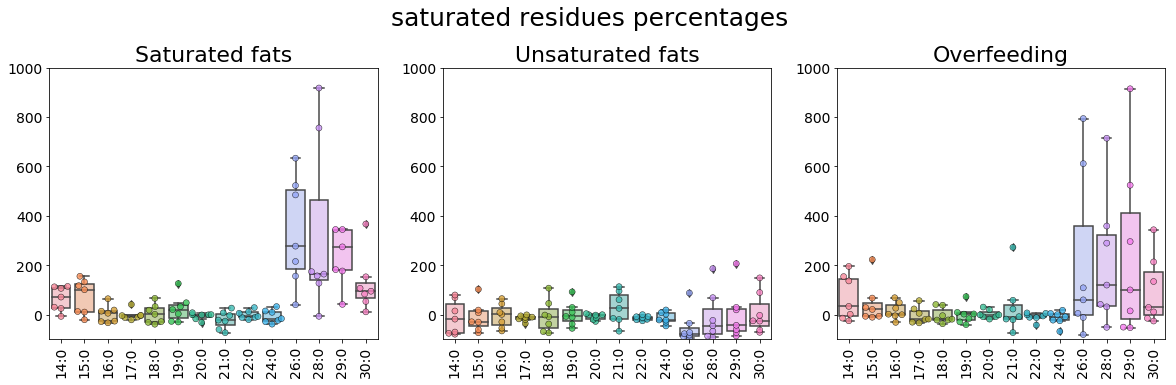

In [59]:
case = "saturated residues percentages"

fig, axes = plt.subplots(1, 3, figsize=(20,5))
label = "diet"
labelled_columns = 1
TITLE_SIZE = 22
TICKSIZE = 14

plt.suptitle(case, y=1.05, size=TITLE_SIZE*1.13)
for i, group in enumerate(('Saturated fats', 'Unsaturated fats', 'Overfeeding')):
    
    axes[i].set_title(f"{group}", size=TITLE_SIZE)
    
    # applying a threshold.
    # ==================================================
    cols = abs(dfperc._get_numeric_data().max()) >= 0 # that is, all of them
    cols_to_keep = cols[cols].index
    table = dfperc[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfperc[dfperc.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])
    box = sns.boxplot(data=table, ax=axes[i], whis=1.5)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=6, alpha=.8, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=TICKSIZE, axis="x")
    axes[i].tick_params(labelsize=TICKSIZE, axis="y")
    axes[i].set_ylim(-100, 1000)

unsaturated residues percentages


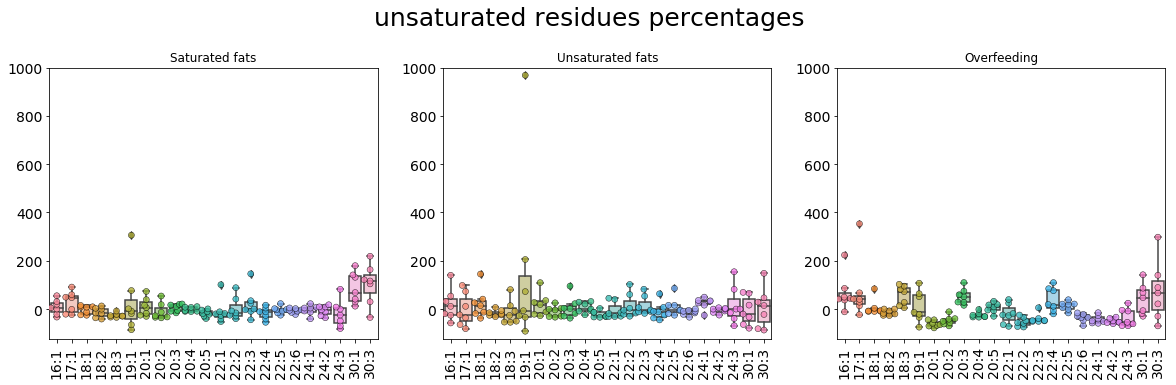

In [57]:
case = "unsaturated residues percentages"

fig, axes = plt.subplots(1, 3, figsize=(20,5))
label = "diet"
labelled_columns = 1
TITLE_SIZE = 22
TICKSIZE = 14

plt.suptitle(case, y=1.05, size=TITLE_SIZE*1.13)
for i, group in enumerate(('Saturated fats', 'Unsaturated fats', 'Overfeeding')):
    
    axes[i].set_title(f"{group}")
    
    # applying a threshold.
    # ==================================================
    cols = abs(dfperc._get_numeric_data().max()) >= 0 # that is, all of them
    cols_to_keep = cols[cols].index
    table = dfperc[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfperc[dfperc.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])
    box = sns.boxplot(data=table, ax=axes[i], whis=2)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=6, alpha=.8, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=TICKSIZE, axis="x")
    axes[i].tick_params(labelsize=TICKSIZE, axis="y")
    axes[i].set_ylim(-125, 1000)

print(case)
#plt.savefig(f"/Users/manz/Desktop/{case}.png", dpi=600, bbox_inches="tight")

There's a clear outlier in the 19:1 residue in Unsaturated fats, that renders the figure hard to read, flattening all the boxes. Let's reduce the span of y-axis:

unsaturated residues percentages (capped)


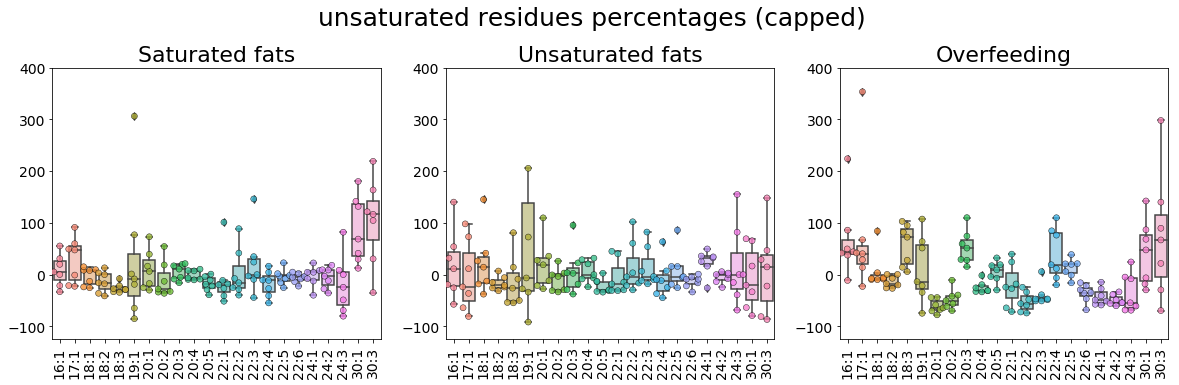

In [60]:
case = "unsaturated residues percentages (capped)"

fig, axes = plt.subplots(1, 3, figsize=(20,5))
label = "diet"
labelled_columns = 1
TITLE_SIZE = 22
TICKSIZE = 14

plt.suptitle(case, y=1.05, size=TITLE_SIZE*1.13)
for i, group in enumerate(('Saturated fats', 'Unsaturated fats', 'Overfeeding')):
    
    axes[i].set_title(f"{group}", size=TITLE_SIZE)
    
    # applying a threshold.
    # ==================================================
    cols = abs(dfperc._get_numeric_data().max()) >= 0 # that is, all of them
    cols_to_keep = cols[cols].index
    table = dfperc[cols_to_keep]
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table.columns]]
    
    # putting back sample labels
    table = pd.concat([table, dfperc[dfperc.columns[-labelled_columns:]]], axis=1)   
    
    table=table[table[label] == group]
    
    # we needed to put back the labels to drop non-group rows, now
    # we just need to plot the numbers
    table=table[table.columns[:-labelled_columns]] # only residue columns
    
    #bar = sns.barplot(data=table, ax=axes[i])
    box = sns.boxplot(data=table, ax=axes[i], whis=2)
    for patch in box.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
    swarm = sns.swarmplot(data=table, ax=axes[i], s=6, alpha=.8, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=TICKSIZE, axis="x")
    axes[i].tick_params(labelsize=TICKSIZE, axis="y")
    axes[i].set_ylim(-125, 400)

This plot look definitely better than the previous one.

# Residues bar plots
## Baseline and treatment

Residue abundance vary greatly. An arbitrary threshold has been chosen to differentiate "abundant" and "less abundant" residues. Charts thus have different y-axis maxima, just for the sake of clarity.

### Plotting saturated residues

In [62]:
# taken from online sample details
baseline_samples = {
"Overfeeding" : ['S00019214', 'S00019216', 'S00019218', 'S00019220', 
                 'S00019222', 'S00019224'],
"Unsaturated fats" : ['S00019196', 'S00019200', 'S00019202', 'S00019204', 
                      'S00019206', 'S00019208',],
"Saturated fats" : ['S00019182', 'S00019184', 'S00019186', 'S00019188', 
                    'S00019190', 'S00019192', 'S00019194'],
}

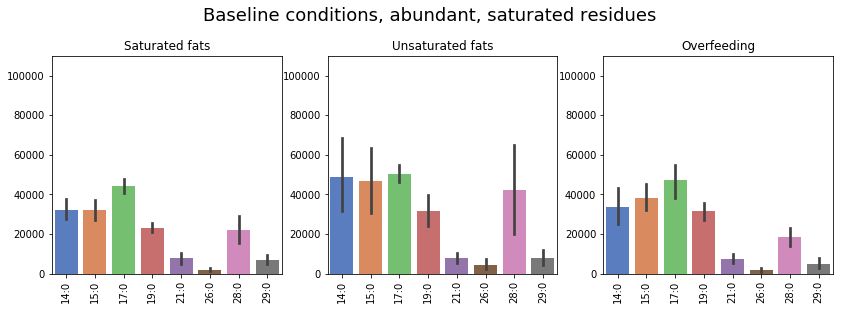

In [63]:
label = "Baseline conditions, abundant, saturated residues"

fig, axes = plt.subplots(1, 3, figsize=(14,4))
plt.suptitle(label, size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    table = data.loc[baseline_samples.get(key), :].copy()
        
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]

    cols = table.max() < 100_000
    cols = cols[cols].index
    table = table[cols]
    BASELINE_COLS = cols.copy()
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 110_000)

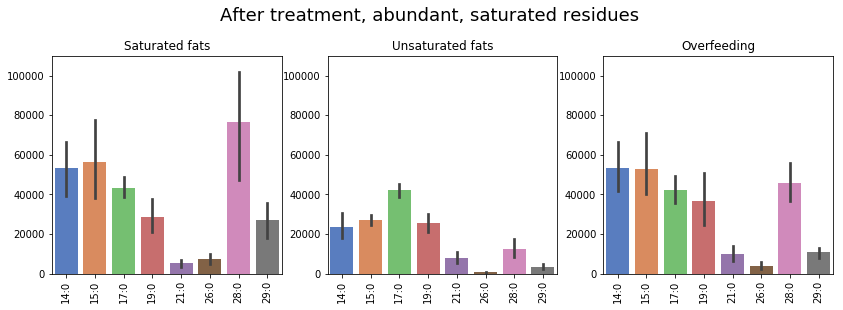

In [64]:
label = "After treatment, abundant, saturated residues"

fig, axes = plt.subplots(1, 3, figsize=(14,4))
plt.suptitle(label, size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    #table = data.loc[baseline_samples.get(key), :].copy()
    table = data[data["diet"] == key].copy()
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]

    # the same as previous plot
    table = table[BASELINE_COLS]
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 110_000)

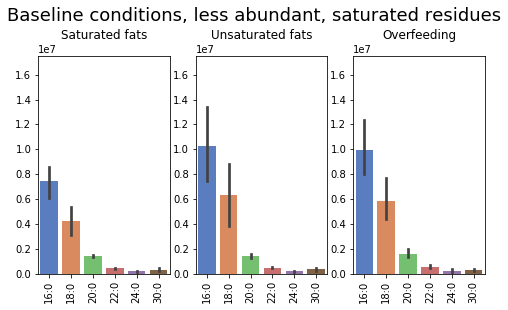

In [68]:
label = "Baseline conditions, less abundant, saturated residues"

fig, axes = plt.subplots(1, 3, figsize=(8,4))
plt.suptitle(label, size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}", y=1.05)
    
    table = data.loc[baseline_samples.get(key), :].copy()
        
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]

    cols = table.max() >= 100_000
    cols = cols[cols].index
    table = table[cols]
    BASELINE_COLS = cols.copy()
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 17_500_000)

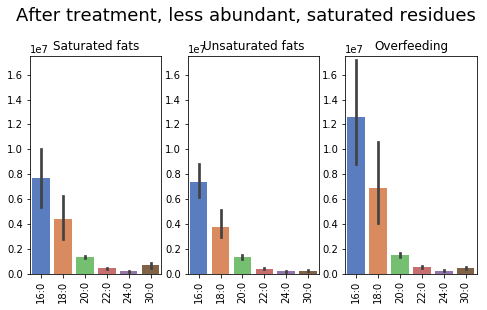

In [69]:
label = "After treatment, less abundant, saturated residues"

fig, axes = plt.subplots(1, 3, figsize=(8,4))
plt.suptitle(label, size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    #table = data.loc[baseline_samples.get(key), :].copy()
    table = data[data["diet"] == key].copy()
    
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]

    # the same as previous plot
    table = table[BASELINE_COLS]
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 17_500_000)

### Plotting unsaturated residues

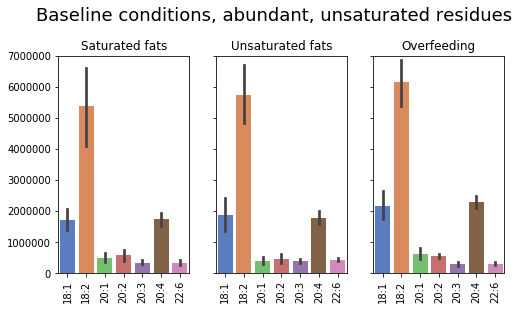

In [70]:
label = "Baseline conditions, abundant, unsaturated residues"

fig, axes = plt.subplots(1, 3, figsize=(8,4))
plt.suptitle(label, size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    table = data.loc[baseline_samples.get(key), :].copy()
        
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]
    
    # these need to be kept the same manually
    if i == 0:
        cols = table.max() > 500_000
        cols = cols[cols].index
    table = table[cols]
    BASELINE_COLS = cols.copy()
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    if i != 0:
        axes[i].set_yticklabels([])
    axes[i].set_ylim(0, 7_000_000)

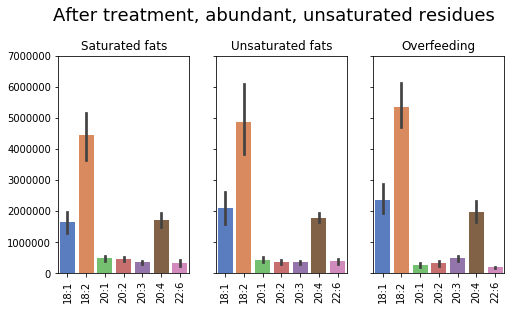

In [72]:
label = "After treatment, abundant, unsaturated residues"

fig, axes = plt.subplots(1, 3, figsize=(8,4))
plt.suptitle(label, size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    #table = data.loc[baseline_samples.get(key), :].copy()
    table = data[data["diet"] == key].copy()
        
    # the same as previous plot
    table = table[BASELINE_COLS]
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    if i != 0:
        axes[i].set_yticklabels([])
    axes[i].set_ylim(0, 7_000_000)

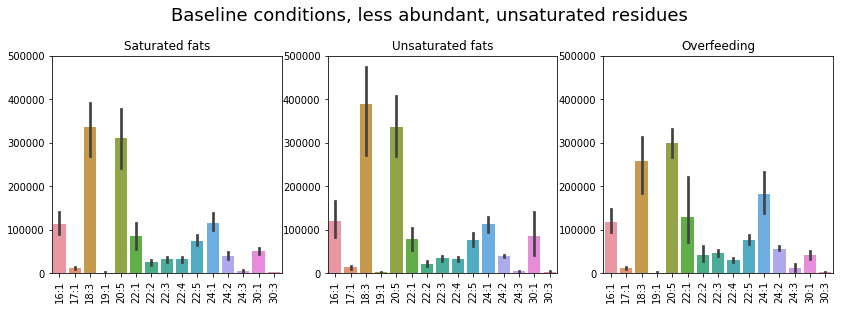

In [74]:
label = "Baseline conditions, less abundant, unsaturated residues"

fig, axes = plt.subplots(1, 3, figsize=(14,4))
plt.suptitle(label, size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    table = data.loc[baseline_samples.get(key), :].copy()
        
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]
    
    # these need to be kept the same manually
    if i == 0:
        cols = table.max() <= 500_000
        cols = cols[cols].index
    table = table[cols]
    BASELINE_COLS = cols.copy()
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 500_000)

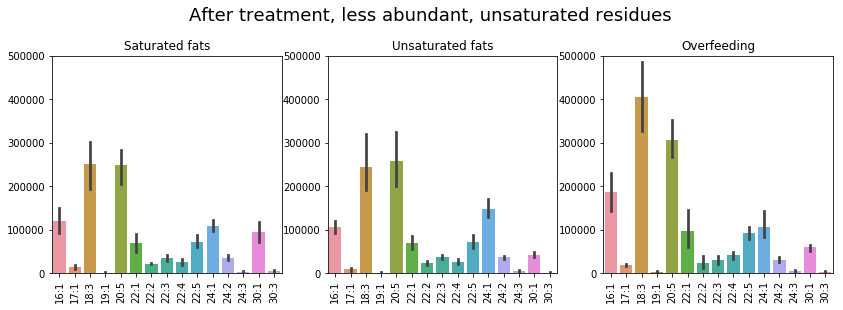

In [75]:
label = "After treatment, less abundant, unsaturated residues"

fig, axes = plt.subplots(1, 3, figsize=(14,4))
plt.suptitle(label, size=18, y=1.05)
labelled_columns = 2

for i, key in enumerate(("Saturated fats", "Unsaturated fats", "Overfeeding")):
    
    axes[i].set_title(f"{key}")
    
    #table = data.loc[baseline_samples.get(key), :].copy()
    table = data[data["diet"] == key].copy()
        
    # saturated or insaturated?
    # =========================
    table = table.loc[:,[not saturated(x) and max_carbon(x, 30) for x in table._get_numeric_data().columns]]
    
    # the same as previous plot
    table = table[BASELINE_COLS]
    
    bar = sns.barplot(data=table, ax=axes[i], 
                      #alpha=.5
                     )
    #swarm = sns.swarmplot(data=table, ax=axes[i], s=10, alpha=.85, edgecolor="black", linewidth=.5)
    axes[i].tick_params(rotation=90, labelsize=10, axis="x")
    axes[i].tick_params(labelsize=10, axis="y")
    axes[i].set_ylim(0, 500_000)